<a href="https://colab.research.google.com/github/twishackaul/Polycystic-Ovarian-Syndrome-Classifier/blob/main/PCOS_Detection_Fusion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Concatenate, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from keras import Sequential
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.regularizers import l2

In [2]:
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
import os

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Ultrasound Data Preprocessing

In [4]:
# ultrasound dataset

!kaggle datasets download -d shnotweta/2000-images-of-ultrasound-for-pcos

Dataset URL: https://www.kaggle.com/datasets/shnotweta/2000-images-of-ultrasound-for-pcos
License(s): unknown
 78% 50.0M/64.5M [00:00<00:00, 109MB/s]
100% 64.5M/64.5M [00:00<00:00, 119MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile("/content/2000-images-of-ultrasound-for-pcos.zip")
zip_ref.extractall("/content")
zip_ref.close()

In [6]:
import os

image_folder = '/content/dataset'
image_files = os.listdir(image_folder)

# Check the first few image filenames
print(image_files[:5])

['normal', 'pcos']


In [7]:
dataset_dir = '/content/dataset'
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        file_path = os.path.join(root, file)
        if os.path.getsize(file_path) == 0:  # Check for zero-byte files
            print(f"Empty file detected and removed: {file_path}")
            os.remove(file_path)  # Remove the empty file

In [8]:
from tensorflow.keras.preprocessing import image

In [9]:
def apply_noise_reduction(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

In [10]:
def augment_image(image):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    image = np.expand_dims(image, axis=0)
    it = datagen.flow(image, batch_size=1)
    return it[0][0]

In [11]:
def load_and_preprocess_images(image_folder, img_size=(256, 256)):
    images = []
    labels = []
    # Get the list of image files from the directory
    for root, dirs, files in os.walk(image_folder):
        for file in files:
            img_path = os.path.join(root, file)

            # Check if the path is a file and has a valid image extension
            if os.path.isfile(img_path) and file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = image.load_img(img_path, target_size = img_size)
                img_array = image.img_to_array(img)
                img_array = img_array / 255.0  # Normalize to [0, 1]
                images.append(img_array)

                # Extract label from directory name or file name
                if 'PCOS' in root.upper() or 'PCOS' in file.upper():
                    labels.append(1)  # PCOS
                else:
                    labels.append(0)  # non-PCOS
            else:
                print(f"Skipping {img_path}, as it is not a valid image file.")

    return np.array(images), np.array(labels)

In [12]:
image_folder = '/content/dataset'
ultrasound_images, ultrasound_labels = load_and_preprocess_images(image_folder)
print("Images shape:", ultrasound_images.shape)
print("Labels shape:", ultrasound_labels.shape)

Images shape: (1987, 256, 256, 3)
Labels shape: (1987,)


### Clinical Data Preprocessing

In [13]:
# clinical data

!kaggle datasets download -d dhawalsakharwade/pcosdataa

Dataset URL: https://www.kaggle.com/datasets/dhawalsakharwade/pcosdataa
License(s): unknown
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 41.9MB/s]


In [14]:
import zipfile
zip_ref = zipfile.ZipFile("/content/pcosdataa.zip")
zip_ref.extractall("/content")
zip_ref.close()

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [16]:
pcos_df = pd.read_csv('/content/data_with_diseases.csv')
pcos_df.head()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 41,Diabetes,Hypertension,Infertility,stressLevel
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,3,3,18.0,18.0,8.5,NaN,0,0,0,1
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,3,5,15.0,14.0,3.7,NaN,0,0,0,2
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,13,15,18.0,20.0,10.0,NaN,1,1,0,3
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,2,2,15.0,14.0,7.5,NaN,0,0,0,2
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,3,4,16.0,14.0,7.0,NaN,0,0,0,2


In [17]:
pcos_df.isnull().sum()

,0
Sl. No,0
Patient File No.,0
PCOS (Y/N),0
Age (yrs),0
Weight (Kg),0
Height(Cm),0
BMI,0
Blood Group,0
Pulse rate(bpm),0
RR (breaths/min),0


In [18]:
pcos_df['Marraige Status (Yrs)'] = pcos_df['Marraige Status (Yrs)'].fillna(pcos_df['Marraige Status (Yrs)'].mean())
pcos_df['Fast food (Y/N)'] = pcos_df['Fast food (Y/N)'].fillna(pcos_df['Fast food (Y/N)'].mean())

In [19]:
clinical_features = pcos_df.drop(columns=['PCOS (Y/N)', 'Patient File No.', 'Sl. No', 'Unnamed: 41', 'stressLevel'])
clinical_labels = pcos_df['PCOS (Y/N)'].values

In [20]:
non_numeric_columns = clinical_features.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index(['AMH(ng/mL)'], dtype='object')


In [21]:
print(clinical_features['AMH(ng/mL)'].unique())

clinical_features['AMH(ng/mL)'] = pd.to_numeric(clinical_features['AMH(ng/mL)'], errors='coerce')

print(clinical_features['AMH(ng/mL)'].isna().sum())

['2.07' '1.53' '6.63' '1.22' '2.26' '6.74' '3.05' '1.54' '1' '1.61' '4.47'
 '1.67' '7.94' '2.38' '0.88' '0.69' '3.78' '1.92' '2.85' '2.13' '4.13'
 '2.5' '1.89' '0.26' '3.84' '3.56' '1.56' '1.69' '2.34' '1.58' '2.36'
 '3.64' '2.78' '0.33' '2.35' '3.88' '3.55' '4.33' '3.66' '4.5' '3.2' '2.1'
 '6.55' '1.2' '2.33' '3.22' '2.333' '2.31' '4.2' '3.21' '2.14' '2.3' '4.6'
 '5.8' '5.2' '4.63' '1.01' '2.58' '0.35' '5.23' '3.68' '2.55' '4.91'
 '1.03' '6.56' '3.91' '5.42' '1.65' '2.06' '1.81' '3.81' '3.65' '8.98'
 '1.7' '3.18' '2.75' '0.86' '2.29' '2.19' '8.46' '4.59' '1.04' '4.27'
 '3.86' '1.42' '10.07' '0.98' '4.07' '3.9' '10' '16.9' '17' '21.9' '1.6'
 '3.3' '21' '12.7' '1.8' '3.6' '15' '5' '17.9' '19.8' '9.2' '2.4' '5.14'
 '0.3' '11.48' '19.3' '8.8' '19' '4.3' '1.4' '12.6' '4.8' '17.1' '11.6'
 '18.4' '9.9' '3.7' '2.9' '2' '4' '15.9' '7.51' '10.04' '6.86' '7.02'
 '8.75' '5.27' '9' '3.41' '0.45' '2.53' '0.29' '2.6' '2.83' '2.01' '5.67'
 '1.68' '3.63' '3.49' '8' '10.25' '32' '3.38' '1.35' '5.78' '4

In [22]:
# Replace non-numeric values with NaN
clinical_features['AMH(ng/mL)'] = pd.to_numeric(clinical_features['AMH(ng/mL)'], errors='coerce')

# Check if there are any remaining NaN values after the replacement
print(clinical_features['AMH(ng/mL)'].isna().sum())

1


In [23]:
clinical_features['AMH(ng/mL)'].fillna(clinical_features['AMH(ng/mL)'].mean(), inplace=True)

In [24]:
print(clinical_features['AMH(ng/mL)'].isna().sum())

0


In [25]:
from sklearn.utils import resample
import numpy as np

def balance_and_sort_datasets(clinical_features, clinical_labels, ultrasound_images, ultrasound_labels):
    # Separate clinical features and labels by class (class 0 and class 1)
    class_0_indices_clinical = np.where(clinical_labels == 0)[0]
    class_1_indices_clinical = np.where(clinical_labels == 1)[0]

    if isinstance(clinical_features, pd.DataFrame):
        clinical_features_class_0 = clinical_features.iloc[class_0_indices_clinical]
        clinical_features_class_1 = clinical_features.iloc[class_1_indices_clinical]
    else:
        # Use regular indexing for NumPy arrays
        clinical_features_class_0 = clinical_features[class_0_indices_clinical]
        clinical_features_class_1 = clinical_features[class_1_indices_clinical]

    # Use [] for NumPy arrays
    clinical_labels_class_0 = clinical_labels[class_0_indices_clinical]
    clinical_labels_class_1 = clinical_labels[class_1_indices_clinical]

    # class_0_clinical = clinical_features[class_0_indices_clinical]
    # class_1_clinical = clinical_features[class_1_indices_clinical]
    # class_0_labels_clinical = clinical_labels[class_0_indices_clinical]
    # class_1_labels_clinical = clinical_labels[class_1_indices_clinical]

    # Upsample clinical data to match the size of ultrasound data (1987 samples total)
    target_samples = 1987

    class_0_clinical_resampled = resample(clinical_features_class_0, replace=True, n_samples=target_samples // 2, random_state=42)
    class_1_clinical_resampled = resample(clinical_features_class_1, replace=True, n_samples=target_samples // 2, random_state=42)

    class_0_labels_resampled = resample(clinical_labels_class_0, replace=True, n_samples=target_samples // 2, random_state=42)
    class_1_labels_resampled = resample(clinical_labels_class_1, replace=True, n_samples=target_samples // 2, random_state=42)

    # Combine the balanced clinical features and labels
    balanced_clinical_features = np.vstack((class_0_clinical_resampled, class_1_clinical_resampled))
    balanced_clinical_labels = np.hstack((class_0_labels_resampled, class_1_labels_resampled))

    # Separate ultrasound features and labels by class (no change in total size)
    class_0_indices_ultrasound = np.where(ultrasound_labels == 0)[0]
    class_1_indices_ultrasound = np.where(ultrasound_labels == 1)[0]

    class_0_ultrasound = ultrasound_images[class_0_indices_ultrasound]
    class_1_ultrasound = ultrasound_images[class_1_indices_ultrasound]
    class_0_labels_ultrasound = ultrasound_labels[class_0_indices_ultrasound]
    class_1_labels_ultrasound = ultrasound_labels[class_1_indices_ultrasound]

    # No need to resample the ultrasound data, just balance the classes within the 1987 samples
    class_0_ultrasound_resampled = resample(class_0_ultrasound, replace=True, n_samples=target_samples // 2, random_state=42)
    class_1_ultrasound_resampled = resample(class_1_ultrasound, replace=True, n_samples=target_samples // 2, random_state=42)

    class_0_labels_resampled = resample(class_0_labels_ultrasound, replace=True, n_samples=target_samples // 2, random_state=42)
    class_1_labels_resampled = resample(class_1_labels_ultrasound, replace=True, n_samples=target_samples // 2, random_state=42)

    # Combine the balanced ultrasound features and labels
    balanced_ultrasound_images = np.vstack((class_0_ultrasound_resampled, class_1_ultrasound_resampled))
    balanced_ultrasound_labels = np.hstack((class_0_labels_resampled, class_1_labels_resampled))

    # Sort datasets based on the labels to align the indexes
    sorted_clinical_indices = np.argsort(balanced_clinical_labels)
    sorted_ultrasound_indices = np.argsort(balanced_ultrasound_labels)

    sorted_clinical_features = balanced_clinical_features[sorted_clinical_indices]
    sorted_clinical_labels = balanced_clinical_labels[sorted_clinical_indices]

    sorted_ultrasound_images = balanced_ultrasound_images[sorted_ultrasound_indices]
    sorted_ultrasound_labels = balanced_ultrasound_labels[sorted_ultrasound_indices]

    return sorted_clinical_features, sorted_clinical_labels, sorted_ultrasound_images, sorted_ultrasound_labels

In [26]:
sorted_clinical_features, sorted_clinical_labels, sorted_ultrasound_images, sorted_ultrasound_labels = balance_and_sort_datasets(clinical_features, clinical_labels, ultrasound_images, ultrasound_labels)

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
scaler = StandardScaler()
sorted_clinical_features = scaler.fit_transform(sorted_clinical_features)

print(sorted_clinical_features.shape, sorted_clinical_labels.shape)

(1986, 41) (1986,)


#### Train Test Split

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.4 MB/s eta 0:00:00


In [31]:
# Defining inputs for both models

# ultrasound_input = Input(shape=(256, 256, 3), name = 'ultrasound_input')   # Ultrasound Image input
# catboost_input = Input(shape=(41,), name = 'catboost_input')               # Clinical data input

In [32]:
from catboost import CatBoostClassifier
catboost_model = CatBoostClassifier()
catboost_model.load_model('/content/Clinical_Classification.cbm')

In [33]:
# getting features for catboost model

catboost_features = catboost_model.predict_proba(sorted_clinical_features)[:, 1]
catboost_features = catboost_features.reshape(-1, 1)                            # Reshape to (num_samples, 1)

In [34]:
resnet_model = tf.keras.models.load_model('/content/Ultrasound_ResNet_50.keras')

In [35]:
for layer in resnet_model.layers[-10:]:  # Unfreezing the last 10 layers for fine-tuning
    layer.trainable = True

In [36]:
resnet_features = resnet_model.predict(sorted_ultrasound_images)
resnet_features = resnet_features.reshape(resnet_features.shape[0], -1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 536s 8s/step


In [41]:
combined_features = np.hstack((resnet_features, catboost_features))

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
combined_features = scaler.fit_transform(combined_features)

In [43]:
labels = sorted_ultrasound_labels

In [44]:
print(f"Combined features shape: {combined_features.shape}")
print(f"Labels shape: {labels.shape}")

Combined features shape: (1986, 2)
Labels shape: (1986,)


In [45]:
train_combined_features, test_combined_features, train_labels, test_labels = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

## Fusion Model

In [46]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score

In [47]:
fusion_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(train_combined_features.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [48]:
fusion_model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [49]:
fusion_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257 (1.00 KB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

In [51]:
history = fusion_model.fit(train_combined_features, train_labels, epochs=20, batch_size=32, validation_split=0.2, verbose = 1, class_weight=class_weights)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7156 - loss: 0.6911 - val_accuracy: 0.8239 - val_loss: 0.5911
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8053 - loss: 0.5751 - val_accuracy: 0.8208 - val_loss: 0.5312
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8338 - loss: 0.5123 - val_accuracy: 0.8113 - val_loss: 0.4958
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8418 - loss: 0.4792 - val_accuracy: 0.8082 - val_loss: 0.4740
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8402 - loss: 0.4584 - val_accuracy: 0.8082 - val_loss: 0.4579
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8388 - loss: 0.4430 - val_accuracy: 0.8082 - val_loss: 0.4472
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8335 - loss: 0.4343 - val_accuracy: 0.8082 - val_loss: 0.4386
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8405 - loss: 0.4287 - val_accuracy: 0.8113 - val_loss:

In [52]:
test_loss, test_accuracy = fusion_model.evaluate(test_combined_features, test_labels, verbose=1)
print(f"Test Accuracy: {test_accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8344 - loss: 0.3860 
Test Accuracy: 0.8291457295417786


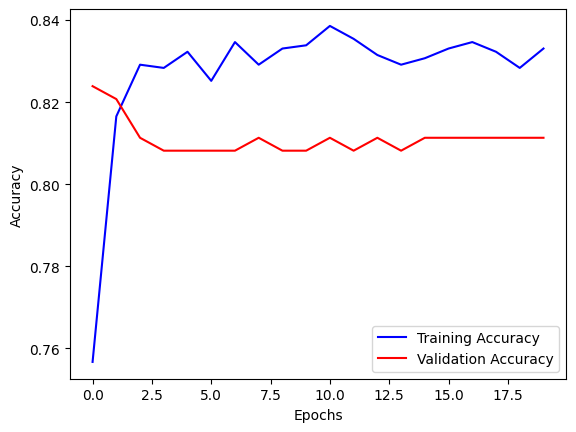

In [53]:
plt.plot(history.history['accuracy'], label='Training Accuracy', color = 'blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

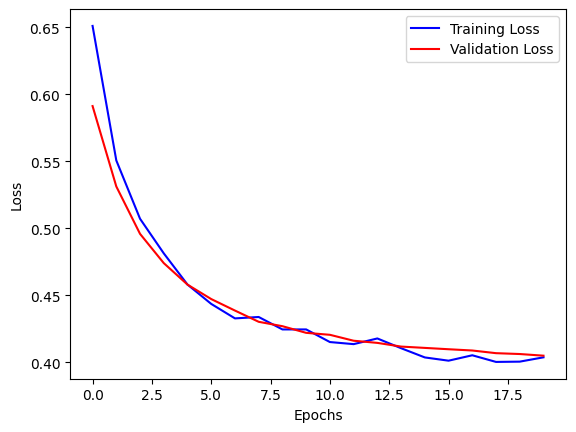

In [54]:
plt.plot(history.history['loss'], label='Training Loss', color = 'blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
y_pred = (fusion_model.predict(test_combined_features) > 0.5).astype("int32")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

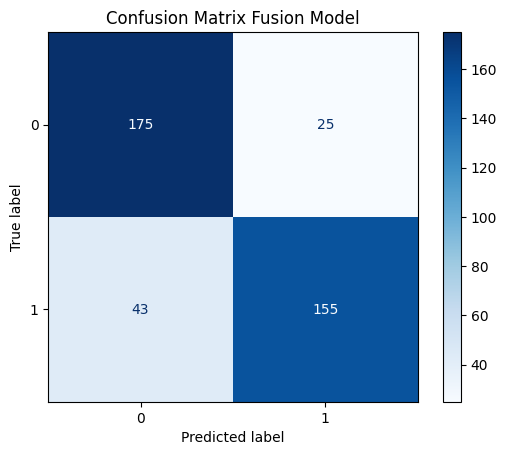

In [57]:
CM = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = CM)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix Fusion Model")
plt.show()

In [58]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       200
           1       0.86      0.78      0.82       198

    accuracy                           0.83       398
   macro avg       0.83      0.83      0.83       398
weighted avg       0.83      0.83      0.83       398



##RandomSearchCV

In [59]:
from sklearn.model_selection import RandomizedSearchCV
import random
from tensorflow.keras.callbacks import EarlyStopping

In [60]:
def create_model(learning_rate, dropout_rate, l2_reg):
    fusion_model_2 = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape = (train_combined_features.shape[1],)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l2_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l2_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l2_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    fusion_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])

    return fusion_model_2

In [61]:
param_dist = {

    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [32],
    'l2_reg': [0.001, 0.01, 0.0001],
    'epochs': [10, 20]
}

In [62]:
best_params = None
best_score = -np.inf

In [63]:
n_iter = 3

In [64]:
# best_model = None

In [65]:
for _ in range(n_iter):
    # Randomly sample a set of hyperparameters
    learning_rate = random.choice(param_dist['learning_rate'])
    dropout_rate = random.choice(param_dist['dropout_rate'])
    l2_reg = random.choice(param_dist['l2_reg'])
    epochs = random.choice(param_dist['epochs'])
    batch_size = random.choice(param_dist['batch_size'])

    print(f"Training model with Random Search: learning_rate = {learning_rate}, dropout = {dropout_rate}, l2_reg = {l2_reg}, epochs = {epochs}, batch_size = {batch_size}")

    # Creating the model
    model = create_model(learning_rate, dropout_rate, l2_reg)

    # Adding EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Training the model
    history = model.fit(train_combined_features, train_labels,
                        validation_split = 0.2,
                        epochs = epochs, batch_size = batch_size,
                        callbacks=[early_stopping], verbose=0, class_weight=class_weights)

    # Get the validation accuracy from the last epoch
    val_acc = history.history['val_accuracy'][-1]

    # If this model's validation accuracy is better than the previous best, store it
    if val_acc > best_score:
        best_score = val_acc
        best_params = {
            'learning_rate': learning_rate,
            'dropout_rate': dropout_rate,
            'l2_reg': l2_reg,
            'epochs': epochs,
            'batch_size': batch_size
        }
        # best_model = model

Training model with Random Search: learning_rate = 0.0001, dropout = 0.3, l2_reg = 0.0001, epochs = 20, batch_size = 32
Training model with Random Search: learning_rate = 0.01, dropout = 0.2, l2_reg = 0.001, epochs = 20, batch_size = 32
Training model with Random Search: learning_rate = 0.01, dropout = 0.2, l2_reg = 0.001, epochs = 20, batch_size = 32


In [66]:
print("Best Validation Accuracy:", best_score)
print("Best Hyperparameters:", best_params)

Best Validation Accuracy: 0.801886796951294
Best Hyperparameters: {'learning_rate': 0.0001, 'dropout_rate': 0.3, 'l2_reg': 0.0001, 'epochs': 20, 'batch_size': 32}


In [67]:
final_model_rd = create_model(learning_rate = best_params['learning_rate'],
                           dropout_rate = best_params['dropout_rate'],
                           l2_reg = best_params['l2_reg'])

history_final = final_model_rd.fit(train_combined_features, train_labels,
                                validation_split = 0.2,
                                epochs = best_params['epochs'],
                                batch_size = best_params['batch_size'], class_weight=class_weights)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5749 - loss: 0.6941 - val_accuracy: 0.7799 - val_loss: 0.6629
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7026 - loss: 0.6611 - val_accuracy: 0.8113 - val_loss: 0.6297
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7797 - loss: 0.6245 - val_accuracy: 0.8176 - val_loss: 0.5969
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7851 - loss: 0.5985 - val_accuracy: 0.8176 - val_loss: 0.5645
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8112 - loss: 0.5617 - val_accuracy: 0.8145 - val_loss: 0.5322
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8360 - loss: 0.5196 - val_accuracy: 0.8239 - val_loss: 0.5039
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8332 - loss: 0.4903 - val_accuracy: 0.8239 - val_loss: 0.4808
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8166 - loss: 0.4808 - val_accuracy: 0.8239 - val_loss

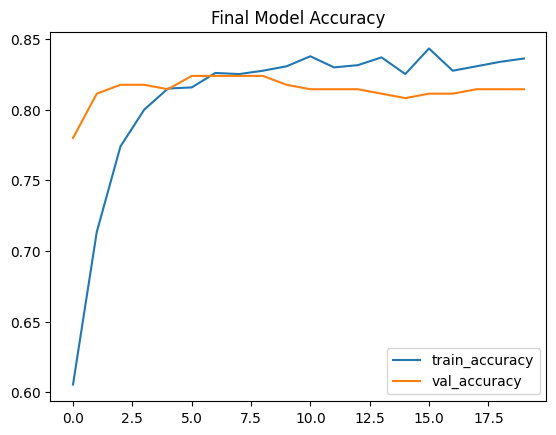

In [68]:
plt.plot(history_final.history['accuracy'], label='train_accuracy')
plt.plot(history_final.history['val_accuracy'], label='val_accuracy')
plt.title('Final Model Accuracy')
plt.legend()
plt.show()

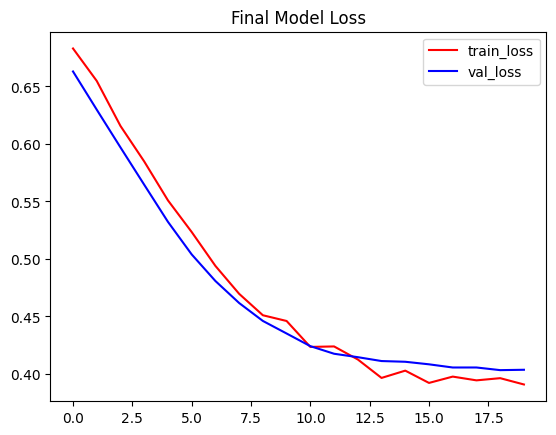

In [69]:
plt.plot(history_final.history['loss'], label='train_loss', color='red')
plt.plot(history_final.history['val_loss'], label='val_loss', color='blue')
plt.title('Final Model Loss')
plt.legend()
plt.show()

In [70]:
y_pred_rd = (final_model_rd.predict(test_combined_features) > 0.5).astype("int32")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


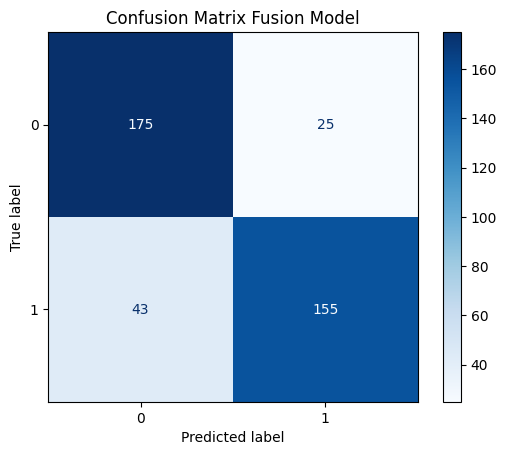

In [71]:
CM = confusion_matrix(test_labels, y_pred_rd)
disp = ConfusionMatrixDisplay(confusion_matrix = CM)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix Fusion Model")
plt.show()

In [72]:
print(classification_report(test_labels, y_pred_rd))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       200
           1       0.86      0.78      0.82       198

    accuracy                           0.83       398
   macro avg       0.83      0.83      0.83       398
weighted avg       0.83      0.83      0.83       398



##GridSearchCV

In [73]:
import itertools

In [74]:
def create_model(learning_rate, dropout_rate, l2_reg):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(train_combined_features.shape[1],)),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [75]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.0001],
    'dropout_rate': [0.3, 0.5, 0.6],
    'l2_reg': [0.01, 0.001, 0.02, 0.0001, 0.002],
    'epochs': [10, 20, 30, 40, 50],
    'batch_size': [64]
}

In [76]:
best_params = None
best_score = -np.inf

In [77]:
best_model = None

In [78]:
param_combinations = list(itertools.product(param_grid['learning_rate'],
                                            param_grid['dropout_rate'],
                                            param_grid['l2_reg'],
                                            param_grid['epochs'],
                                            param_grid['batch_size']))

In [79]:
for combination in param_combinations:
    # Unpack the combination
    learning_rate, dropout_rate, l2_reg, epochs, batch_size = combination

    print(f"Training model with Grid Search: learning_rate = {learning_rate}, dropout = {dropout_rate}, l2_reg = {l2_reg}, epochs = {epochs}, batch_size = {batch_size}")

    # Create the model
    model = create_model(learning_rate, dropout_rate, l2_reg)

    # Add EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(train_combined_features, train_labels,
                        validation_split = 0.2,
                        epochs=epochs, batch_size=batch_size,
                        callbacks=[early_stopping], verbose=0, class_weight = class_weights)

    # Get the validation accuracy from the last epoch
    val_acc = history.history['val_accuracy'][-1]

    # If this model's validation accuracy is better than the previous best, store it
    if val_acc > best_score:
        best_score = val_acc
        best_params = {
            'learning_rate': learning_rate,
            'dropout_rate': dropout_rate,
            'l2_reg': l2_reg,
            'epochs': epochs,
            'batch_size': batch_size
        }

        best_model = model

Training model with Grid Search: learning_rate = 0.001, dropout = 0.3, l2_reg = 0.01, epochs = 10, batch_size = 64
Training model with Grid Search: learning_rate = 0.001, dropout = 0.3, l2_reg = 0.01, epochs = 20, batch_size = 64
Training model with Grid Search: learning_rate = 0.001, dropout = 0.3, l2_reg = 0.01, epochs = 30, batch_size = 64
Training model with Grid Search: learning_rate = 0.001, dropout = 0.3, l2_reg = 0.01, epochs = 40, batch_size = 64
Training model with Grid Search: learning_rate = 0.001, dropout = 0.3, l2_reg = 0.01, epochs = 50, batch_size = 64
Training model with Grid Search: learning_rate = 0.001, dropout = 0.3, l2_reg = 0.001, epochs = 10, batch_size = 64
Training model with Grid Search: learning_rate = 0.001, dropout = 0.3, l2_reg = 0.001, epochs = 20, batch_size = 64
Training model with Grid Search: learning_rate = 0.001, dropout = 0.3, l2_reg = 0.001, epochs = 30, batch_size = 64
Training model with Grid Search: learning_rate = 0.001, dropout = 0.3, l2_reg

In [80]:
print("Best Validation Accuracy:", best_score)
print("Best Hyperparameters:", best_params)

Best Validation Accuracy: 0.8396226167678833
Best Hyperparameters: {'learning_rate': 0.01, 'dropout_rate': 0.5, 'l2_reg': 0.02, 'epochs': 30, 'batch_size': 64}


In [81]:
final_model_grid = create_model(learning_rate = best_params['learning_rate'],
                           dropout_rate = best_params['dropout_rate'],
                           l2_reg = best_params['l2_reg'])

In [82]:
history_final_2 = final_model_grid.fit(train_combined_features, train_labels,
                                validation_split = 0.2,
                                epochs = best_params['epochs'],
                                batch_size = best_params['batch_size'], class_weight = class_weights)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6703 - loss: 6.2869 - val_accuracy: 0.8333 - val_loss: 1.1564
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8023 - loss: 1.0029 - val_accuracy: 0.8176 - val_loss: 0.6895
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7987 - loss: 0.7050 - val_accuracy: 0.7956 - val_loss: 0.6591
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8005 - loss: 0.6579 - val_accuracy: 0.8208 - val_loss: 0.5470
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8020 - loss: 0.6024 - val_accuracy: 0.7925 - val_loss: 0.6561
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8054 - loss: 0.6211 - val_accuracy: 0.8019 - val_loss: 0.6005
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8176 - loss: 0.5852 - val_accuracy: 0.8113 - val_loss: 0.5278
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8081 - loss: 0.5803 - val_accuracy: 0.8019 - va

In [83]:
final_model_grid.summary()

Model: "sequential_230"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1368 (Dense)                   │ (None, 512)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1138 (Dropout)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1369 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1139 (Dropout)               │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1370 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1140 (Dropout)               │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1371 (Dense)                   │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1141 (Dropout)               │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1372 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1142 (Dropout)               │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1373 (Dense)                   │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,389 (2.02 MB)

 Trainable params: 176,129 (688.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 352,260 (1.34 MB)

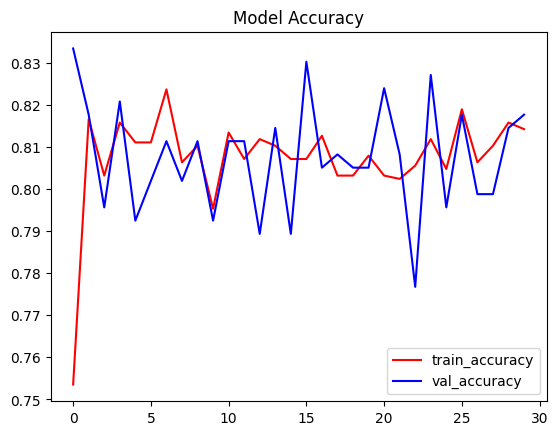

In [91]:
plt.plot(history_final_2.history['accuracy'], label='train_accuracy', color = 'red')
plt.plot(history_final_2.history['val_accuracy'], label='val_accuracy', color = 'blue')
plt.title('Model Accuracy')
plt.legend()
plt.show()

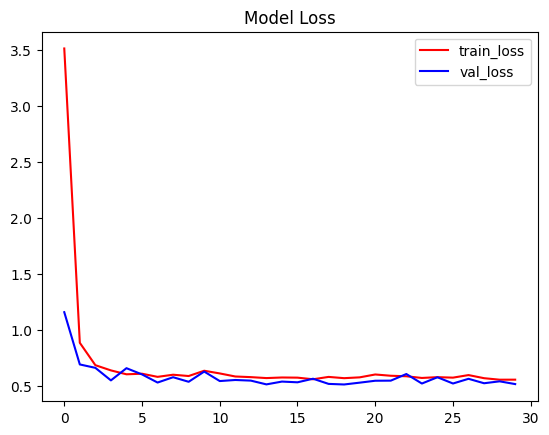

In [92]:
plt.plot(history_final_2.history['loss'], label='train_loss', color='red')
plt.plot(history_final_2.history['val_loss'], label='val_loss', color='blue')
plt.title('Model Loss')
plt.legend()
plt.show()

In [86]:
y_pred_grid = (final_model_grid.predict(test_combined_features) > 0.5).astype("int32")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


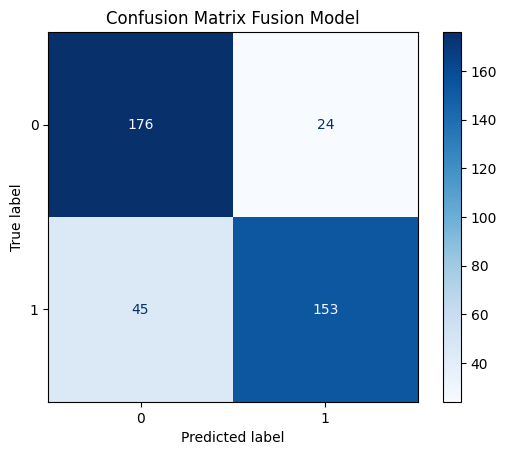

In [93]:
CM = confusion_matrix(test_labels, y_pred_grid)
disp = ConfusionMatrixDisplay(confusion_matrix = CM)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix Fusion Model")
plt.show()

In [88]:
print(classification_report(test_labels, y_pred_grid))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       200
           1       0.86      0.77      0.82       198

    accuracy                           0.83       398
   macro avg       0.83      0.83      0.83       398
weighted avg       0.83      0.83      0.83       398



In [94]:
final_model_grid.save('fusion_model.keras')